# 决策树（Decision Tree）ID3算法

## 概述
决策树是一个预测模型；他代表的是对象属性与对象值之间的一种映射关系。树中每个节点表示某个对象，而每个分叉路径则代表的某个可能的属性值，而每个叶结点则对应从根节点到该叶节点所经历的路径所表示的对象的值。决策树仅有单一输出，若欲有复数输出，可以建立独立的决策树以处理不同输出。数据挖掘中决策树是一种经常要用到的技术，可以用于分析数据，同样也可以用来作预测。
> **优点**：计算复杂度不高，输出结果易于理解，对中间值的缺失不敏感，可以处理不想管特征数据  
> **缺点**：可能会产生过拟合问题  
> **使用数据类型**：数值型和标称型  

相较于KNN，决策树的主要优势在于数据形式非常容易理解

## 算法流程
1. 收集数据：可以使用任何方法
2. 准备数据：树构造算法值适用于标称型数据，因此数值型数据必须离散化
3. 分析数据：可以使用任何方法，构造树完成之后，我们应该检查图形是否符合预期
4. 训练算法：构造树的数据结构
5. 测试算法：使用经验树计算错误率
6. 使用算法：此步骤可以适用于任何监督学习算法，而使用决策树可以更好的理解数据的内在含义

## 信息增益（information gain)
划分数据集的大原则是，将无序的数据变得更加有序。我们可以有多种方法划分数据集，但是每种方法都有各自的优缺点。  
在划分数据集之前之后信息发生的变化称为信息增益，获得信息增益最高的特征就是最好的选择。

## 熵（entropy）
集合信息的度量方式称为香农熵或简称熵，这个名字来源于信息论之父克劳德·香农。
熵定义为信息的期望值。如果待分类的事物可能划分在多个分类之中，则符号$x_i$的信息定义为
$$l(x_i)=-log_2p(x_i)$$
$p(x_i)$是选择该分类的概率。
为了计算熵，需要计算所有类别所有可能值包含的信息期望值，公式如下
$$H=-\sum_{i=1}^np(x_i)log_2p(x_i)$$
$n$是分类的数目

In [5]:
from math import log

def calcShannonEnt(dataSet):
    '''
    计算给定数据集的熵
    '''
    # 获取数据集示例数量
    numEntries = len(dataSet)
    # 构造分类标签字典
    labelCounts = {}
    
    # 遍历数据集，获取分类标签数量
    for featVec in dataSet:
        curLable = featVec[-1]
        if curLable not in labelCounts.keys():
            labelCounts[curLable] = 0
        labelCounts[curLable] += 1
    # 遍历分类标签，计算熵
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob, 2)
    
    return shannonEnt

海洋生物数据，如下

||不浮出水面是否可以生存|是否有脚蹼|属于鱼类|
|--|--|--|--|
|1|是|是|是|
|2|是|是|是|
|3|是|否|否|
|4|否|是|否|
|5|否|是|否|


根据海洋生物数据构造数据集

In [6]:
def createDataSet():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing', 'flippers']
    return dataSet, labels

计算数据集的熵

In [7]:
dataSet, labels = createDataSet()
calcShannonEnt(dataSet)

0.9709505944546686

熵越大，则代表混合的数据越多。

In [8]:
dataSet[0][-1]='maybe' # 增加一个新的分类maybe
calcShannonEnt(dataSet)

1.3709505944546687

分类增加，导致熵变大。

## 划分数据集
分类算法除了需要测量数据集的无序程度，还需要划分数据集，度量划分数据集的无序程度，以便判断当前划分是否正确。

In [9]:
def splitDataSet(dataSet, axis, value):
    '''
    按照给定特征划分数据集
    param dataSet: 待划分的数据集
    param axis: 划分数据集的特征
    param value: 需要返回的特征的值
    '''
    retDataSet = []
    # 遍历数据集，返回给定特征等于特定值的示例集
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

例如我们要以特征“不浮出水面是否可以生存”进行划分，然后返回可以生存的示例

In [10]:
splitDataSet(dataSet, 0, 1)

[[1, 'maybe'], [1, 'yes'], [0, 'no']]

现在需要通过计算熵，找到最好的划分数据的方式

In [11]:
def chooseBestFeatureToSplit(dataSet):
    '''
    选择最好的数据划分方式
    '''
    # 特征值数量
    numFeatures = len(dataSet[0]) - 1
    # 数据集划分前的熵
    baseEntropy = calcShannonEnt(dataSet)
    # 最优的信息增益
    bestInfoGain = 0.0
    # 最优的数据划分特征
    bestFeature = -1
    
    # 遍历特征，对每个特征进行数据划分，找到最优信息增益的特征
    for i in range(numFeatures):
        # 创建唯一的特征值列表
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        # 数据划分后的熵
        newEntropy = 0.0
        
        # 按照指定特征进行数据划分，并计算数据划分后的熵
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
        
        # 找到最优信息增益所对应的特征值
        infoGain = baseEntropy - newEntropy
        if(infoGain > bestInfoGain):
            bestInfoGain = infoGain
            bestFeature = i
    
    return bestFeature

用海洋生物数据进行测试，发现第一次最优的数据划分特征是“不浮出水面是否可以生存”

In [12]:
chooseBestFeatureToSplit(dataSet)

0

## 递归构造决策树
由于特征值可能不止一个，因此存在大于两个分支的数据集划分。划分一次后，数据将被向下传递到树分支节点，进行再次划分。因此可以采用递归的原则处理数据。  
伪代码如下：  

if 类别相同  
&emsp;&emsp;return 该类别  
elif　遍历完所有特征  
&emsp;&emsp;return 返回数量最多的类别  
elif  
&emsp;&emsp;寻找划分数据的最好特征  
&emsp;&emsp;划分数据集  
&emsp;&emsp;创建分支节点  
&emsp;&emsp;for 每个划分的子集  
&emsp;&emsp;&emsp;&emsp;调用函数createTree并增加返回结果到分支节点中  
&emsp;&emsp;return 分支节点  

In [13]:
import operator

def majorityCnt(classList):
    '''
    获取次数最多的分类名称
    '''
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    
    sortedClassCount = sorted(classCount.iteritems(),
                             key=operator.itemgetter(1),
                             reversed=True)
    return sortedClassCount[0][0]

def createTree(dataSet, labels):
    # 数据集的所有分类
    classList = [example[-1] for example in dataSet]
    # 类别完全相同则停止划分
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    # 遍历完所有特征时返回次数最多的类别
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    
    # 选择数据划分最优特征并构建树
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    
    # 划分数据集，创建分支节点，并递归分支节点
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(
            splitDataSet(dataSet, bestFeat, value), subLabels)
        
    return myTree

用海洋生物数据集进行测试。可以发现返回值是一个嵌套的字典类型。如果字典的值是数据字典，代表这是一个分支节点；如果字典的值是一个特定值，那么代表这是一个叶节点。

In [14]:
dataSet, labels = createDataSet()
createTree(dataSet, labels)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

## 使用文本注解绘制树节点

In [15]:
# -.- coding:utf-8 -.-
import matplotlib.pyplot as plt
import matplotlib as mpl

# 绘图中文显示
mpl.rcParams['font.sans-serif'] = ['KaiTi']
mpl.rcParams['font.serif'] = ['KaiTi']

# 定义文本框和箭头格式
desisionNode = dict(boxstyle='sawtooth', fc='0.8')
leafNode = dict(boxstyle='round4', fc='0.8')
arrow_args = dict(arrowstyle='<-')

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    '''
    绘制带箭头的注解
    param nodeTxt: 注解
    param centerPt: 箭头所在坐标
    param parentPt: 箭尾所在坐标
    param nodeType: 节点样式
    '''
    createPlot.ax1.annotate(nodeTxt, 
                            xy=parentPt, 
                            xycoords='axes fraction', 
                            xytext=centerPt, 
                            textcoords='axes fraction', 
                            va='center', 
                            ha='center', 
                            bbox=nodeType, 
                            arrowprops=arrow_args)
    
def createPlot():
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    createPlot.ax1 = plt.subplot(111, frameon=False)
    plotNode(u'决策节点', (0.5, 0.1), (0.1, 0.5), desisionNode)
    plotNode(u'叶节点', (0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()

测试注解方法

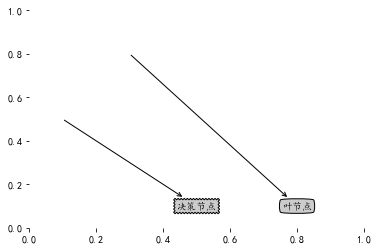

In [16]:
createPlot()

## 构造注解树
首先需要知道有多少个叶节点，以便确定x轴的长度；还需要知道树有多少层，以便确定y轴的高度。

In [17]:
def getNumLeafs(myTree):
    '''
    获取叶节点数量
    '''
    numLeafs = 0
    firstStr = myTree.keys()[0]
    secondDict = myTree[firstStr]
    # 如果子节点为字典，继续递归，否则叶节点数量加1
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
            
    return numLeafs

def getTreeDepth(myTree):
    '''
    获取树的深度
    '''
    maxDepth = 0
    firstStr = myTree.keys()[0]
    secondDict = myTree[firstStr]
    # 递归计算子节点最大深度
    for key in secondDict.keys():
        if type(secondDict[key]).__name__== 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    
    return maxDepth

def retrieveTree(i):
    '''
    测试用树信息,树列表中包含了两颗树
    '''
    listOfTrees = [{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}]
    return listOfTrees[i]

测试方法

In [18]:
print getNumLeafs(retrieveTree(0))
print getTreeDepth(retrieveTree(0))

3
2


构造树型注解

In [19]:
def plotMidText(cntrPt, parentPt, txtString):
    '''
    父子节点间填充文本
    '''
    xMid = (parentPt[0] - cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)
    
def plotTree(myTree, parentPt, nodeTxt):
    # 计算树的高和宽
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = myTree.keys()[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, desisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    # 递归画出分支节点
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
    
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    # 计算树的高度与宽度，并保存与全局变量中
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()

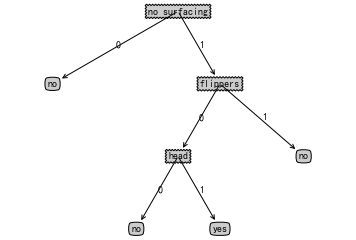

In [20]:
myTree = retrieveTree(1)
createPlot(myTree)

## 使用决策树进行分类

In [21]:
def classify(inputTree, featLabels, testVec):
    '''
    决策树的分类函数
    param inputTree: 训练用树决策树
    param featLables: 训练用分类标签
    param testVec: 用于分类的输入向量
    '''
    firstStr = inputTree.keys()[0]
    secondDict = inputTree[firstStr]
    # 根节点对应特征标签列表的索引值
    featIndex = featLabels.index(firstStr)
    # 递归遍历树，比较testVec变量中的值与树节点的值，如果达到叶子节点，则返回当前节点的分类标签
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                classLabel = secondDict[key]
    
    return classLabel

输入测试数据[1, 0]，即不浮出水面可以生存， 没有脚蹼的海洋生物，根据决策树分类结果为不属于鱼类

In [22]:
dataSet, labels = createDataSet()
myTree = retrieveTree(0)
print labels
print myTree
print classify(myTree, labels, [1, 0])

['no surfacing', 'flippers']
{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
no


In [23]:
[1,1][0]

1

## 决策树的存储
构造决策树是非常耗时的任务，然后用构建耗的决策树解决分类问题，则可以很快完成。因此，在每次执行分类时最好调用已经构造好的决策树。为了保存决策树，可以使用pickle序列化对象，将其保存在磁盘中，并在需要的时候读取出来。

In [24]:
def storeTree(inputTree, filename):
    '''
    序列化对象并保存至指定路径
    '''
    import pickle
    fw = open(filename, 'w')
    pickle.dump(inputTree, fw)
    fw.close()
    
def grabTree(filename):
    '''
    读取文件并反序列化
    '''
    import pickle
    fr = open(filename)
    return pickle.load(fr)

In [25]:
storeTree(myTree, 'classifierStorage.txt')

In [26]:
grabTree('classifierStorage.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

通过对决策树的存储，不用在每次对数据分类时重新学习一遍，这也是决策树的优点之一。而k近邻算法就无法持久化分类器。

## 示例：使用决策树预测隐形眼镜类型
1. 收集数据：提供的文本文件  
2. 准备数据：解析tab分割的数据行
3. 分析数据：快速检查数据，确保正确的解析数据内容，使用createPlot()函数绘制最终的属性图
4. 训练算法：使用createTree()函数
5. 测试算法：编写测试函数验证决策树可以正确分类给定的数据实例
6. 使用算法：存储树的数据结构，以便下次使用时无需重新构造树

In [27]:
# 读取数据文件
fr = open('lenses.txt')
# 解析tab分割符
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
# 构造特征标签
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
# 训练算法
lensesTree = createTree(lenses, lensesLabels)

In [28]:
lensesTree

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}},
      'young': 'soft'}},
    'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses',
        'presbyopic': 'no lenses',
        'young': 'hard'}},
      'myope': 'hard'}}}},
  'reduced': 'no lenses'}}

图形化显示决策树，更能直观的看出划分情况。沿着决策树的不同分支，就能得到不同患者需要佩戴的隐形眼镜类型。

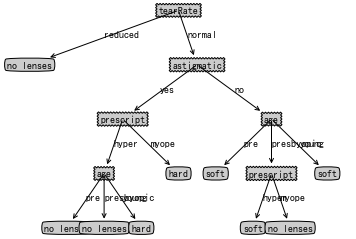

In [29]:
createPlot(lensesTree)

可以看出该决策树非常好的匹配了实验数据，但是匹配项可能太多了，会造成过拟合。为了减少过度匹配的问题，可以裁剪决策树，去掉一些不必要的叶子节点。

## 总结
ID3算法无法直接处理数值型数据，可以用户划分标称型数据集。构造决策树时，通常使用递归的方法将数据集转化为决策树。  
除了ID3算法以外，还有其他决策树的构造算法，最流行的是C4.5和CART

In [30]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(lenses, lensesLabels)

ValueError: could not convert string to float: young

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')